In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sys
from numba import jit
from IPython.display import display, update_display
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# Metodos auxiliares
%run metodos.ipynb

In [3]:
# Constantes necesarias
path_instancias_facebook = F"./instancias"
path_egofacebook = F"{path_instancias_facebook}/ego-facebook-analisis"
path_egofacebook_edge = F"{path_egofacebook}/ego-facebook.edges"
path_egofacebook_feat = F"{path_egofacebook}/ego-facebook.feat"
path_graficos = './graficos/facebook'

## Metodo de la potencia - Ejecución de C++

**_Nota:_** Dado que las instancias generadas para la experimentacion con Facebook pesan 2.5 GBs no fueron incluidas en la entrega. Se incluye el siguiente parametro para poder probar la ejecucion del notebook usando Numpy. Todos los resultados y graficos fueron obtenidos con el metodo de la potencia implementado en C++

In [ ]:
execute_using_numpy = False

Definimos a continuacion dos metodos.

El primero se encarga de correr nuestro codigo compilado de C++ y devolver la tupla de autovalores y autovectores como Numpy.

El segundo metodo es para facilidad de pruebas. Permite correr el metodo de la potencia usando Numpy o nuestro metodo. Tambien, como nuestro metodo utiliza text files para el output, por defecto se van a buscar los resultados ya obtenidos, y se devuelven estos, a menos que se especifique lo contrario. Por ultimo los autovalores y autovectores se ordenan de menor a mayor para devolverlos en el mismo orden que Numpy. Esto ayuda a compararlos.

In [4]:
def correr_metodo_potencia(matriz, iteraciones=1e3, epsilon=1e-8, matriz_name='test'):
    filename = f'{matriz_name}.txt'
    filepath = f'{path_egofacebook}/experimentos'
    imprimir_matriz(filepath, filename, matriz)

    process = subprocess.Popen(
        ["./metodo_potencia", f'{filepath}/{filename}', str(iteraciones), str(epsilon)], 
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stdin=subprocess.PIPE,
        universal_newlines = True)
    exit_code = process.wait()
    if exit_code != 0: 
        print(F"Hubo un error en el metodo de la potencia")

    process.stdin.close()
    process.stdout.close()
    process.stderr.close()

    return (obtener_matriz(f'{filepath}/{filename}-autovalores.out'), obtener_matriz(f'{filepath}/{filename}-autovectores.out'))

def metodo_potencia(matriz, matriz_name, rerun=False):
    if execute_using_numpy:
        return np.linalg.eigh(matriz)
    
    filepath = f'{path_egofacebook}/experimentos'
    filename = f'{matriz_name}.txt'

    if rerun:
        autovalores, autovectores = correr_metodo_potencia(matriz, matriz_name=matriz_name)
    else:
        try:
            autovalores = obtener_matriz(f'{filepath}/{filename}-autovalores.out')
            autovectores = obtener_matriz(f'{filepath}/{filename}-autovectores.out')
        except FileNotFoundError:
            autovalores, autovectores = correr_metodo_potencia(matriz, matriz_name=matriz_name)

    autotupla = [(autovalores[i], autovectores[:, i]) for i in range(len(autovalores))]
    autotupla.sort(key=lambda tup: tup[0])
    
    return (np.array([tup[0] for tup in autotupla]), np.array([tup[1] for tup in autotupla]).T)

# Computar la matriz de similaridad

Nuestro objetivo es reconstruir la red de amistad de Facebook a partir de la matriz de atributos, y validar que tan parecida es esta a la red original

In [5]:
facebook_data = obtener_matriz(path_egofacebook_feat)

# Separo por un lado los labels de los nodos, y por el otro los atributos
facebook_labels = facebook_data[:,0]
facebook_attributes = facebook_data[:,1:]


Primero reconstruimos la matriz de adyacencia de la red original a partir de la matriz de ejes de la red

In [6]:
@jit(nopython=True)
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

In [7]:
facebook_friends_edges = obtener_matriz(path_egofacebook_edge)

facebook_friends_matriz_adyacencia = np.zeros((len(facebook_labels), len(facebook_labels)))

for edge in facebook_friends_edges:
    [a, b] = edge

    i = find_first(a, facebook_labels)
    j = find_first(b, facebook_labels)

    facebook_friends_matriz_adyacencia[i][j] = 1
    facebook_friends_matriz_adyacencia[j][i] = 1


A continuacion creamos la matriz de similaridad haciendo el producto entre la matriz de atributos y su traspuesta.

Definimos ademas un metodo que nos permite, a partir de un umbral, construir la matriz de adyacencia. Para cada celda A_ij de la matriz de similaridad, se considera que existe un eje entre los nodos i y j si el valor de la matriz de similaridad supera el umbral. La diagonal se rellena con 0.

In [8]:
# Construimos la matriz de similaridad
matriz_similaridad = facebook_attributes @ facebook_attributes.T

def construir_matriz_adyacencia(umbral, matriz=matriz_similaridad):
    matriz_adyacencia = (matriz > umbral).astype(float)
    np.fill_diagonal(matriz_adyacencia, 0) # Ponemos en 0 la diagonal para mejorar la visualizacion de conexiones

    return matriz_adyacencia


Seleccionamos un umbral determinado. Los valores de la matriz de similaridad son enteros, por lo que elegimos el umbral 7 y graficamos la red resultante

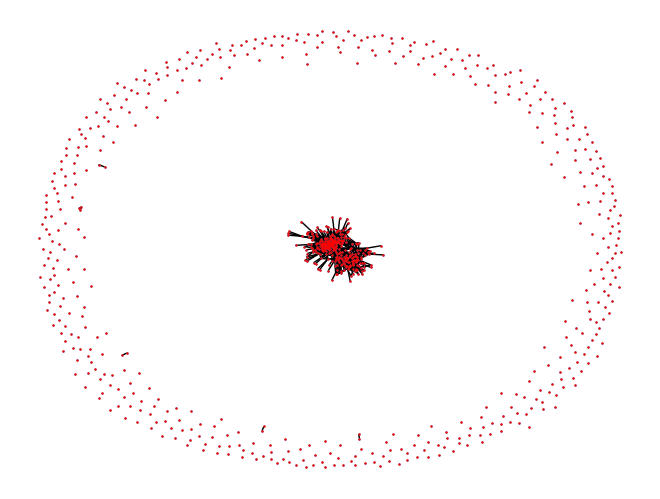

In [9]:
def graficar_adyacencia_para_umbral(umbral):
    seed = 12345

    G = nx.from_numpy_array(construir_matriz_adyacencia(umbral))
    pos = nx.spring_layout(G, seed=seed)

    nx.draw(G, pos, node_size=0.4)

    nx.draw_networkx_nodes(G, pos = pos, node_size= 0.5, node_color='r')
    nx.draw_networkx_edges(G, pos = pos, node_size = 0.5, width=0.1)

umbral_seleccionado = 7

graficar_adyacencia_para_umbral(umbral_seleccionado)
plt.savefig(f'{path_graficos}/adyacencia_umbral_{umbral_seleccionado}')

Observemos ahora la red original de amistad

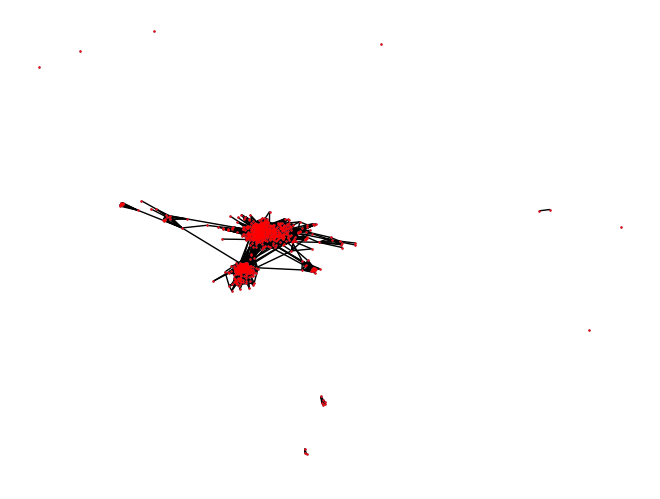

In [33]:
seed = 12345

G = nx.from_numpy_array(facebook_friends_matriz_adyacencia)
pos = nx.spring_layout(G, seed=seed)

nx.draw(G, pos, node_size=0.4)

nx.draw_networkx_nodes(G, pos = pos, node_size= 0.5, node_color='r')
nx.draw_networkx_edges(G, pos = pos, node_size = 0.5, width=0.1)

plt.show()

# Comparacion con los datos originales

Queremos comparar la red de amistades original y la construida a partir de los datos. Las visualizacions de la red no nos ayudan mucho, por lo que computaremos las siguientes metricas,
1) Comparar las redes mediante la correlacion de las matrices de adyacencia estiradas a un vector (flatten)
2) Comparar utilizando la correlacion entre las listas de autovalores de las matrices de adyacencia

Ambos metodos utilizan la correlacion entre vectores, por lo que definimos primero este metodo


In [10]:
def correlacion_entre_vectores(x,y):
    centered_x = (x - x.mean())
    centered_y = (y - y.mean())

    producto_centrado = np.dot(centered_x, centered_y)
    factor_normalizacion = np.dot(centered_x, centered_x) * np.dot(centered_y, centered_y)
    if factor_normalizacion != 0:
        return producto_centrado / np.sqrt(factor_normalizacion)
    return producto_centrado

Veamos primero como se comparan haciendo un conteo de vinculos que coinciden entre la red original y la construida

In [51]:
matriz_seleccionada = construir_matriz_adyacencia(umbral_seleccionado)
amistades = 0
no_amistades = 0
dif = 0
for i in range(len(matriz_seleccionada)):
    for j in range(i, len(matriz_seleccionada)):
        temp = facebook_friends_matriz_adyacencia[i,j] + matriz_seleccionada[i,j]
        if (temp == 2):
            amistades += 1
        elif (temp == 0):
            no_amistades += 1
        else:
            dif += 1

print(f'Amistades que coinciden: {amistades}')
print(f'Faltas de amistad que coinciden: {no_amistades}')
print(f'Diferencias: {dif}')


amistades_originales = 0
for i in range(len(facebook_friends_matriz_adyacencia)):
    for j in range(i, len(facebook_friends_matriz_adyacencia)):
        if(facebook_friends_matriz_adyacencia[i,j] == 1):
            amistades_originales += 1

print(f'\nAmistades en red original: {amistades_originales}, diferencia con predecida: {amistades_originales-amistades}')

Amistades que coinciden: 379
Faltas de amistad que coinciden: 298866
Diferencias: 14783

Amistades en red original: 14024, diferencia con predecida: 13645


Vemos que pareciera que la aproximacion no es muy buena si contamos solo las amistades que coinciden. Sin embargo es dificil de estimar utilizando estas metricas, pues la mayoria de los vinculos posibles (amistades) entre dos nodos no ocurren.

No podemos medir la eficacia de la aproximacion contando solo las amistades que coinciden, ya que una reconstruccion que sea optimista en la generacion de amistades probablemente tenga alta eficacia en predecir una amistad de la red original, pero introduzca muchas amistades no existentes.

Por otro lado, si nuestra aproximacion es muy conservadora, habra muchos "matcheos", ya que no generara muchas amistades falsas, pero tampoco aproximara bien las amistades que realmente existen. Necesitamos entonces metricas que nos permitan elegir un unico valor por el cual optimizar.

## Comparacion mediante la correlacion de matrices de adyacencia estiradas

Definimos un metodo para calcular la correlacion entre dos matrices, que no hace mas que aplicarles el metodo flatten y calcular la correlacion entre los vectores resultantes

In [11]:
def correlacion_entre_matrices_flatten(A, B):
    x = A.flatten()
    y = B.flatten()

    return correlacion_entre_vectores(x, y)


Y calculamos la correlacion flatten para nuestro umbral seleccionado

In [12]:
correlacion_entre_matrices_flatten(facebook_friends_matriz_adyacencia, construir_matriz_adyacencia(umbral_seleccionado))

0.06919137913197829

# Comparacion mediante la correlacion de los autovalores de las matrices de adyacencia

Otra forma de comparar las redes resultantes es calcular los autovalores de la matriz de adyacencia de la red original y de nuestra red generada a partir de un umbral, y calcular la correlacion entre ambas listas de autovalores. Para esto aplicamos nuestra implementacion del metodo de la potencia.

Primero aplicamos el metodo de la potencia sobre la red original, ya que estos autovalores nos serviran mas adelante.

In [13]:
facebook_friends_autovalores, _ = metodo_potencia(facebook_friends_matriz_adyacencia, matriz_name='facebook_friends')

Y ahora definimos un metodo para calcular la correlacion entre autovalores para la matriz de adyacencia generada a partir de determinado umbral. Podemos probarlo sobre nuestro umbral seleccionado en los puntos anteriores

In [14]:
def correlacion_entre_autovalores(umbral):
    autovalores_B, _ = metodo_potencia(construir_matriz_adyacencia(umbral), matriz_name=f'similaridad_umbral_{umbral}')

    return correlacion_entre_vectores(facebook_friends_autovalores, autovalores_B, )

correlacion_entre_autovalores(umbral_seleccionado)

0.9277614648280634

Ahora vamos a probar como varian ambas correlaciones a medida que vamos modificando el umbral. Definimos un tope en 15 y probamos para todos los valores enteros entre 0 y 15.

In [15]:
umbrales = range(15)
correlaciones_flatten = []
correlaciones_autovalores = []

display('Umbral 0', display_id='umbral')
for umbral in umbrales:
    update_display(f'Umbral {umbral}', display_id='umbral')
    correlaciones_flatten.append(correlacion_entre_matrices_flatten(facebook_friends_matriz_adyacencia, construir_matriz_adyacencia(umbral)))
    correlaciones_autovalores.append(correlacion_entre_autovalores(umbral))

'Umbral 14'

0.9527950124656754
0.10987884773144667


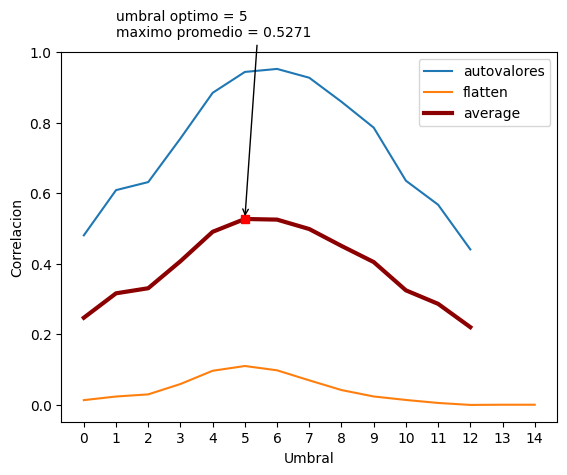

In [16]:
x_axis = np.arange(len(umbrales))
width = 0.75

data = pd.DataFrame({
    'autovalores': correlaciones_autovalores,
    'flatten': correlaciones_flatten,
    'average': [(correlaciones_flatten[i] + correlaciones_autovalores[i]) / 2 for i in range(len(correlaciones_flatten))]
})

data[['autovalores','flatten']].plot(legend=True)
data['average'].plot(color='darkred', lw=3, legend=True)

umbral_optimo = data.idxmax()['average']

xmax = umbral_optimo
ymax = data['average'][umbral_optimo]
plt.plot(xmax, ymax, 'rs')
plt.annotate(
    "umbral optimo = {:n}\nmaximo promedio = {:.4f}".format(xmax, ymax),
    xy=(xmax, ymax),
    xytext=(1,data['autovalores'][umbral_optimo]+0.1),
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=86")
)

plt.xlabel("Umbral")
plt.ylabel("Correlacion")
plt.xticks(umbrales)

plt.savefig(f'{path_graficos}/umbral_optimo.png')

print(max(correlaciones_autovalores))
print(max(correlaciones_flatten))

Vemos en esta figura que ambas metricas comienzan bajas, aumentan a medida que aumentos el umbral hasta llegar a un maximo, y luego comienzan a bajar. Esto es esperado, ya que para umbrales bajos estaremos generando muchas amistades que no existian en la red original, disminuyendo la correlacion. Por otro lado, para umbrales muy altos estaremos siendo muy restrictivos al generar amistades, por lo que estaremos perdiendo amistades que estaban en la red original.

El umbral que maximiza el promedio entre ambas metricas de correlacion es 5.

# Filtrar la matriz de atributos usando PCA

Queremos a continuacion explorar que sucede al realizar los mismos experimentos anteriores, pero al filtrar la matriz de atributos utilizando PCA.

Para esto veremos que sucede al solo dejar _k_ componentes principales y modificar el umbral, y repetiremos este proceso para distintos valores de _k_.

Definimos entonces la matriz centrada de atributos, calculamos la matriz de covarianzas, y sacamos sus autovectores para obtener la matriz de cambio de base. Por ultimo definimos un metodo que permite proyectar la matriz de atributos centrada usando _k_ componentes principales

In [17]:
facebook_attributes_centered = facebook_attributes - facebook_attributes.mean()

C = (facebook_attributes_centered.T @ facebook_attributes_centered) / (len(facebook_attributes_centered) - 1)

_, facebook_attributes_centered_autovectores = metodo_potencia(C, 'facebook_attributes_centered')

def proyectar_attributes_usando_PCA(k):
    return facebook_attributes_centered @ facebook_attributes_centered_autovectores[:, -k:]

facebook_attributes_centered_autovectores.shape

(319, 319)

Definimos tambien un metodo que nos permitira graficar toda esta informacion, de forma tal de ver lo que sucede con cada valor de _k_ al modificar el umbral, y cual es el valor 'esperado' de correlacion, que obtuvimos al analizar la matriz de atributos completa.

In [18]:
def graficar_resultado_pca(resultado, ks, umbrales, expected=[], x_float=False, save=''):
    df = pd.DataFrame(data=resultado)

    df.plot.line()

    tick_labels = umbrales
    if x_float:
        tick_labels = ['{:.1f}'.format(umbral) for umbral in umbrales]

    plt.xticks(np.arange(len(umbrales)), tick_labels)
    plt.xlabel('umbral')
    plt.ylabel('Correlacion')
    plt.title('Correlacion por umbral para\ndistinta cantidad de componentes principales')

    legend = list(ks)
    if len(expected) > 0:
        plt.plot(umbrales, expected, color='black', zorder=10, lw=3)
        legend += ['sin filtro']
    
    leg = plt.legend(legend, loc='center', bbox_to_anchor=(0., -0.35, 1., 0.102), title='k', ncols=6)

    if len(save) == 0:
        plt.show()
    else:
        plt.savefig(f'{path_graficos}/{save}', bbox_extra_artists=[leg], bbox_inches='tight')

El experimento entonces es muy similar al anterior, solo que ademas de variar el umbral, vamos variando el k. Definimos una progresion geometrica para los valores de k a probar, ya que esperamos que los valores bajos de k tengan diferencias notables, pero a partir de cierto punto no se modifiquen mucho los resultados aumentando el k.

In [19]:
k_config = {
    'min': 1,
    'max': 100,
    'count': 30
}

umbrales = range(13)

ks = np.unique(np.geomspace(k_config['min'], k_config['max'], k_config['count'], dtype=int))
print(f'ks a ser probados: {ks}')
resultado_flatten = np.zeros((len(umbrales), len(ks)))
resultado_autovalores = np.zeros((len(umbrales), len(ks)))

display('progress', display_id='progress')
for i in range(len(ks)):
    k = ks[i]
    update_display(f'Proyectando con PCA y k: {k}', display_id='progress')
    matriz_atributos_proyectada = proyectar_attributes_usando_PCA(k)

    for umbral in umbrales:
        update_display(f'k: {k}, umbral: {umbral}', display_id='progress')
        matriz_similaridad_proyectada = construir_matriz_adyacencia(umbral, matriz=(matriz_atributos_proyectada @ matriz_atributos_proyectada.T))
        
        autovalores, _ = metodo_potencia(matriz_similaridad_proyectada, matriz_name=f'similaridad_pca_{k}_componentes_umbral_{umbral}')

        resultado_flatten[umbral][i] = correlacion_entre_matrices_flatten(facebook_friends_matriz_adyacencia, matriz_similaridad_proyectada)
        resultado_autovalores[umbral][i] = correlacion_entre_vectores(facebook_friends_autovalores, autovalores)


ks a ser probados: [  1   2   3   4   5   6   7   9  10  12  14  17  20  23  28  32  38  45
  52  62  72  85 100]


'k: 100, umbral: 12'

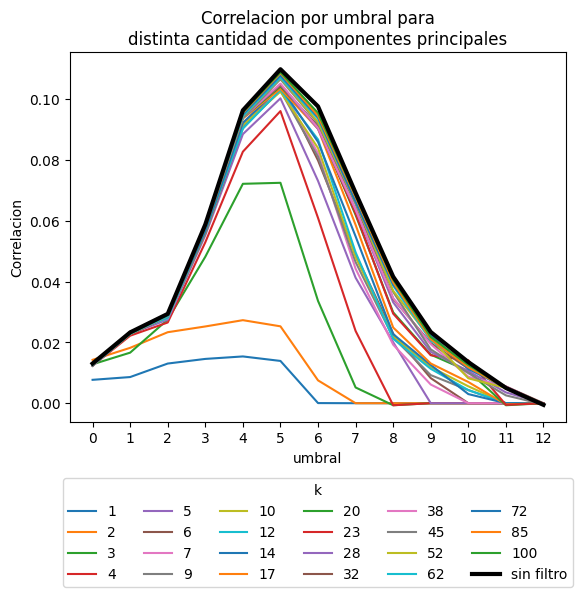

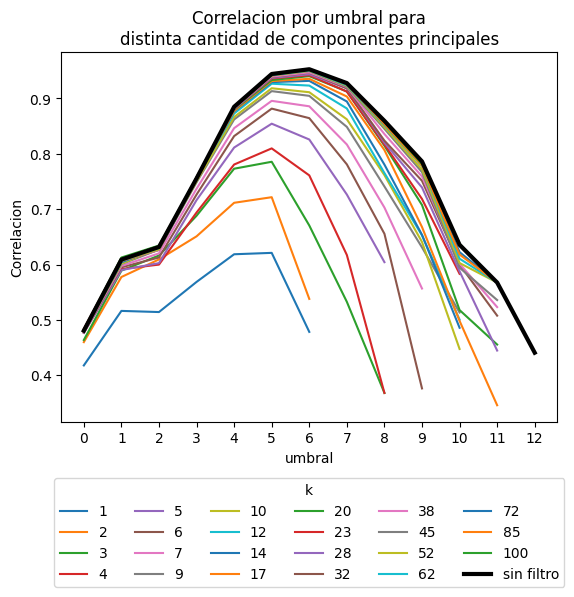

In [20]:
graficar_resultado_pca(resultado_flatten, ks, umbrales, correlaciones_flatten[:len(umbrales)], save='correlacion_pca_flatten.png')
graficar_resultado_pca(resultado_autovalores, ks, umbrales, correlaciones_autovalores[:len(umbrales)], save='correlacion_pca_av.png')

Vemos que, efectivamente, para valores bajos de componentes principales los valores de correlacion obtenidos son mas bajos. Esto refleja que contamos con menos informacion de los atributos que tienen los usuarios.

Sin embargo, a partir de cierto valor de _k_ alrededor de 9 la diferencia con el resultado sin filtrar comienza a ser menor, sobre todo si utilizamos el umbral optimo calculado anteriormente. Tambien podemos observar que la metrica de correlacion entre matrices de adyacencia flattened converge mas rapidamente a los valores sin filtro.

## Probando valores no enteros de umbral

Otro efecto de utilizar la proyeccion de los atributos usando PCA es que la matriz de similaridad ya no esta compuesta unicamente de numeros enteros, por lo que podemos realizar este mismo experimento para valores no enteros de umbral. Para esto hacemos un 'zoom' alrededor del valor optimo que conseguimos y obtenemos 15 umbrales equidistantes entre 3 y 7. Tambien probaremos con menos valores de k ya que ya nos hicimos una idea de como se comportan los valores al modificar el k por los experimentos anteriores

In [21]:
k_config = {
    'min': 10,
    'max': 50,
    'count': 5
}

umbrales_float = np.linspace(3,7, 15)
print(f'umbrales a ser probados: {umbrales_float}')

ks_umbral_float = np.unique(np.geomspace(k_config['min'], k_config['max'], k_config['count'], dtype=int))
print(f'ks a ser probados: {ks_umbral_float}')

resultado_umbral_medio = np.zeros((len(umbrales_float), len(ks_umbral_float)))
resultado_umbral_medio_av = np.zeros((len(umbrales_float), len(ks_umbral_float)))

display('progress', display_id='progress')
for i in range(len(ks_umbral_float)):
    k = ks_umbral_float[i]
    update_display(f'Proyectando con PCA y k: {k}', display_id='progress')
    matriz_atributos_proyectada = proyectar_attributes_usando_PCA(k)

    for j in range(len(umbrales_float)):
        umbral = umbrales_float[j]
        update_display(f'k: {k}, umbral: {umbral}', display_id='progress')
        matriz_similaridad_proyectada = construir_matriz_adyacencia(umbral, matriz=(matriz_atributos_proyectada @ matriz_atributos_proyectada.T))

        autovalores, _ = metodo_potencia(matriz_similaridad_proyectada, matriz_name=f'similaridad_pca_{k}_componentes_umbral_{umbral}')

        resultado_umbral_medio[j][i] = correlacion_entre_matrices_flatten(facebook_friends_matriz_adyacencia, matriz_similaridad_proyectada)
        resultado_umbral_medio_av[j][i] = correlacion_entre_vectores(facebook_friends_autovalores, autovalores)

umbrales a ser probados: [3.         3.28571429 3.57142857 3.85714286 4.14285714 4.42857143
 4.71428571 5.         5.28571429 5.57142857 5.85714286 6.14285714
 6.42857143 6.71428571 7.        ]
ks a ser probados: [10 14 22 33 50]


'k: 50, umbral: 7.0'

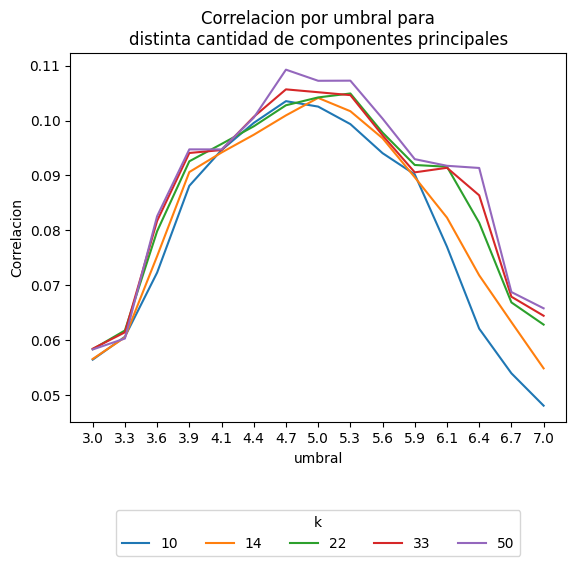

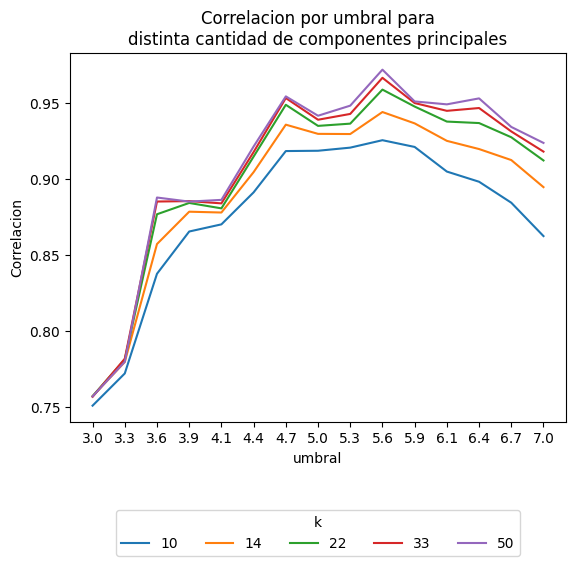

In [22]:
graficar_resultado_pca(resultado_umbral_medio, ks_umbral_float, umbrales_float, x_float=True, save='correlacion_pca_float_flatten.png')
graficar_resultado_pca(resultado_umbral_medio_av, ks_umbral_float, umbrales_float, x_float=True, save='correlacion_pca_float_av.png')

In [23]:
print(f'Maxima correlacion flatten PCA:\n{resultado_umbral_medio.max()}')
print(f'Maxima correlacion flatten:\n{max(correlaciones_flatten)}\n')

print(f'Maxima correlacion autovalores PCA:\n{resultado_umbral_medio_av.max()}')
print(f'Maxima correlacion autovalores:\n{max(correlaciones_autovalores)}')


Maxima correlacion flatten PCA:
0.10926935518963118
Maxima correlacion flatten:
0.10987884773144667

Maxima correlacion autovalores PCA:
0.9717936150705662
Maxima correlacion autovalores:
0.9527950124656754


Podemos observar en los graficos que los valores no enteros de umbral nos permiten aumentar de cierta forma la resolucion del grafico, y esto puede llevarnos a una matriz de adyacencia que tiene mejor correlacion con la matriz original que al no filtrar usando PCA.

Esto ocurre para el caso de correlacion usando autovalores, donde la maxima correlacion obtenida es mayor que la maxima correlacion obtenida sin filtrar usando PCA. Podemos intuir que lo mismo sera cierto para la metrica de correlacion flatten si utilizamos mayor granularidad en los umbrales o mayores valores de _k_.